# Pawpularity Score: pretrained EfficientNet (NOT with "imagenet")

In [1]:
import os
import random
import math
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import lightgbm as lgb
#from cuml.svm import SVR
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import & split data into train, validation and test set 

In [2]:
# Constants
AUTOTUNE = tf.data.experimental.AUTOTUNE  
img_size = 224
channels = 3
Batch_size = 16

# Directory for dataset
train_dir = "/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train/"
test_dir = "/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test/"

def seed_everything():
    os.environ['PYTHONHASHSEED'] = str(123)
    np.random.seed(123)
    random.seed(123)
    tf.random.set_seed(123)
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'
    os.environ['PYTHONHASHSEED'] = str(123)

seed_everything()

In [3]:
# Reading dataset train, test in df and df_test respectively
df = pd.read_csv("/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train.csv")
df_test = pd.read_csv("/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test.csv")
Id = df_test["Id"].copy()


# Converting Id column for taking images
df["Id"] = df["Id"].apply(lambda x : train_dir + x + ".jpg")
df_test["Id"] = df_test["Id"].apply(lambda x : test_dir + x + ".jpg")

In [4]:
# Defining functions for reading and augmentation of images
# A seperate function for creating dataset

# Augmenting the image
def image_preprocess(is_labelled):  
    def augment(image):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_contrast(image, 0.95, 1.05)
        return image
    
    def can_be_augmented(img, label):
        return augment(img), label
    
#   If record has label both image and lable will be returned
    return can_be_augmented if is_labelled else augment



# Reading and rescaling images
def image_read(is_labelled):
    def decode(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=channels)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (img_size, img_size))
        image = tf.keras.applications.efficientnet.preprocess_input(image)
        return image
    
    def can_be_decoded(path, label):
        return decode(path), label
    
#   If record has label both image and lable will be returned
    return can_be_decoded if is_labelled else decode


# Creating the dataset
def create_dataset(df, df_meta, batch_size, is_labelled = False, augment = False, shuffle = False):
    image_read_fn = image_read(is_labelled)
    image_preprocess_fn = image_preprocess(is_labelled)
    
    if is_labelled:
        dataset = tf.data.Dataset.from_tensor_slices((df["Id"].values, df_meta.values))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((df["Id"].values))
    
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(image_preprocess_fn, num_parallel_calls=AUTOTUNE) if augment else dataset
#     dataset = dataset.shuffle(1024, reshuffle_each_iteration=True) if shuffle else dataset
#     dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def create_metadata_dataset(df, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((df["Pawpularity"].values))
#     dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
#     dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset 

def create_metadata_dataset_test(df, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((df.values))
#     dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
#     dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def create_metadata(df, lab,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((df.values, lab['Pawpularity'].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def create_metadata_test(df,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((df.values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [5]:
# Defining train, validation and test set 
trn = df.iloc[:9000]
val = df.iloc[9001:]
tes = np.zeros((df_test.shape[0],),dtype='float32')
tes = pd.DataFrame(tes)

xtrain_att_trn = trn.drop(["Id", "Pawpularity"],axis=1)
xtrain_att_val = val.drop(["Id", "Pawpularity"],axis=1)
test_att = df_test.drop(["Id"],axis=1)
xtrain_att_trn.astype('float32')
xtrain_att_val.astype('float32')
test_att.astype('float32')
train = create_dataset(trn, xtrain_att_trn,Batch_size, is_labelled = True, augment = False, shuffle = False)
validation = create_dataset(val, xtrain_att_val,Batch_size, is_labelled = True, augment = False, shuffle = False)
test = create_dataset(df_test, test_att,Batch_size, is_labelled = True, augment = False, shuffle=False)
train_att = create_metadata(xtrain_att_trn, trn,Batch_size)
test_att = create_metadata_test(test_att,Batch_size)

# Defining xtrain_att, ytrain_att for MLP

ytrain_trn = create_metadata_dataset(trn, Batch_size)
ytrain_val = create_metadata_dataset(val, Batch_size)
test_val = create_metadata_dataset_test(tes, Batch_size)

train = tf.data.Dataset.zip((train, ytrain_trn)).batch(Batch_size)
validation = tf.data.Dataset.zip((validation, ytrain_val)).batch(Batch_size)
test = tf.data.Dataset.zip((test, test_val)).batch(Batch_size)

Metal device set to: Apple M1 Pro


# Loading (local) pretrained EfficientNet

In [6]:
img_mod = "/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/EfficientNetB0.h5"
efnet = tf.keras.models.load_model(img_mod)
efnet.trainable = False

In [7]:
# Using pretrained EfficientNet with image size of (224,224,3)
# Using relu activation function because it a regression problem

inp1 = Input(shape=(img_size, img_size, channels))
x = efnet(inp1)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

inp2 = Input(shape=(12))
con = Concatenate()([x, inp2])
x = Dense(units = 64, activation="relu")(con)
out = Dense(units = 1)(x)

model = Model([inp1, inp2], out)

In [8]:
# Early stopping helps as it stops training if val_loss(validation score) does not decrease.
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1, #1e-3,
    decay_steps=100000, decay_rate=0.96,
    staircase=True)

# Compiling and Fitting the model

In [9]:
model.compile(loss="mse", 
              optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [10]:
predictor = model.fit(train,
                      epochs=50, 
                      validation_data = validation,
                      callbacks = [early_stopping])

Epoch 1/50
563/563 [==============================] - 49s 72ms/step - loss: 493.6566 - root_mean_squared_error: 22.2184 - val_loss: 349.3980 - val_root_mean_squared_error: 18.6922
Epoch 2/50
563/563 [==============================] - 36s 63ms/step - loss: 436.2912 - root_mean_squared_error: 20.8876 - val_loss: 370.6093 - val_root_mean_squared_error: 19.2512
Epoch 3/50
563/563 [==============================] - 35s 63ms/step - loss: 430.4643 - root_mean_squared_error: 20.7476 - val_loss: 377.6157 - val_root_mean_squared_error: 19.4323
Epoch 4/50
563/563 [==============================] - 36s 63ms/step - loss: 418.7774 - root_mean_squared_error: 20.4641 - val_loss: 403.6403 - val_root_mean_squared_error: 20.0908
Epoch 5/50
563/563 [==============================] - 36s 64ms/step - loss: 426.3382 - root_mean_squared_error: 20.6480 - val_loss: 403.7392 - val_root_mean_squared_error: 20.0933
Epoch 6/50
563/563 [==============================] - 36s 64ms/step - loss: 426.3650 - root_mean_squ

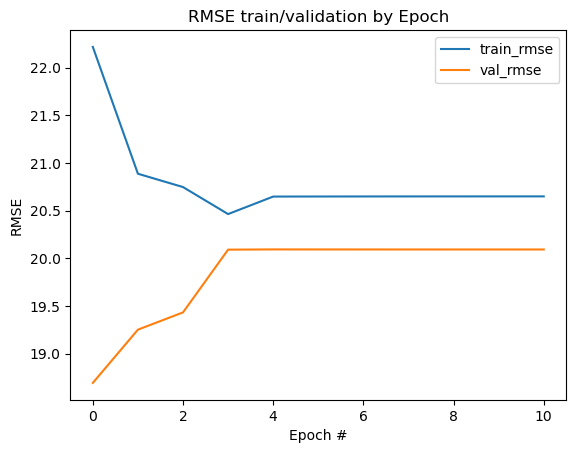

In [11]:
plt.figure()
plt.plot(predictor.history["root_mean_squared_error"], label="train_rmse")
plt.plot(predictor.history["val_root_mean_squared_error"], label="val_rmse")
#plt.xticks(range(0,60))
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right")

# Prediction

In [12]:
# Making prediction on test set
pred1 = model.predict(test)

1/1 [==============================] - 2s 2s/step


In [13]:
pred1

array([[43.865547],
       [43.88186 ],
       [43.898792],
       [43.575573],
       [43.336697],
       [44.79013 ],
       [42.64801 ],
       [42.682743]], dtype=float32)